#Introduction
This notebook is used for training YOLOv7 network for a crack detection on the concrete surfaces. It is trained on the custom dataset that consist of 11 298 pictures of cracks.

#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [ ]:
!pip install wandb

#Connect to Google Drive where our dataset is located
from google.colab import drive
drive.mount('/content/drive')


# Download YOLOv7 repository and install requirements
!git clone https://github.com/WongKinYiu/yolov7
%cd yolov7
!pip install -r requirements.txt



Mounted at /content/drive
Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197 (from 1)
Receiving objects: 100% (1197/1197), 74.23 MiB | 16.26 MiB/s, done.
Resolving deltas: 100% (519/519), done.
/content/yolov7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.8 MB/s e

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
#This opens file explorer in Google Colab
from google.colab import files
files.view('.')

<IPython.core.display.Javascript object>

# Split dataset into train/val/test subsets




Check if all images have their corresponding txt labels in dataset folder.

In [ ]:
import os
import zipfile

# Define the path to your ZIP file and extraction folder
zip_path = "/content/drive/MyDrive/Amphibian Robot/Dataset/Dataset Prueba 2/crack_detection_dataset_v2.zip"
extract_path = "/content/drive/MyDrive/Amphibian Robot/Dataset_final"  # Destination folder

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")


KeyboardInterrupt: 

In [ ]:
train_dataset_path = "/content/drive/MyDrive/Amphibian Robot/Dataset_final/crack_detection_dataset_v2/train"

In [ ]:
import os
import zipfile
# Count the number of images and label files
num_images = 0
num_labels = 0
num_missing_labels = 0

# Loop through the images in the data folder
for image_file in os.listdir(train_dataset_path):
    if image_file.endswith(".jpg"):
        num_images += 1
        label_file = os.path.join(train_dataset_path, image_file[:-4] + ".txt")
        if os.path.isfile(label_file):
            num_labels += 1
        else:
            num_missing_labels += 1
            print(f'Missing label: {label_file}')

# Print the results
print("Number of images:", num_images)
print("Number of label files:", num_labels)
print("Number of missing label files:", num_missing_labels)

Number of images: 9603
Number of label files: 9603
Number of missing label files: 0


Separate data from a main dataset folder to a train/val/test folders, as YOLOv7 network requires.

In [ ]:
#Set split ratio, remaining ratio is for test subset
train_ratio, val_ratio = 0.8, 0.10
limit_number_of_images_to = None # Set to None if you want to use all images
seed = 1

In [ ]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split

# Paths
train_data_path = "/content/drive/MyDrive/Amphibian Robot/Dataset_final/crack_detection_dataset_v2/train"
test_data_path = "/content/drive/MyDrive/Amphibian Robot/Dataset_final/crack_detection_dataset_v2/evaluation"

main_path = "/content/drive/MyDrive/Amphibian Robot/Dataset/crack_detection_dataset_v2"

# Train & Validation Paths
train_images_path = os.path.join(main_path, "images/train")
val_images_path = os.path.join(main_path, "images/val")

train_labels_path = os.path.join(main_path, "labels/train")
val_labels_path = os.path.join(main_path, "labels/val")

# Test Paths
test_images_path = os.path.join(main_path, "images/test")
test_labels_path = os.path.join(main_path, "labels/test")

# Create directories if they don't exist
for path in [train_images_path, val_images_path, train_labels_path, val_labels_path, test_images_path, test_labels_path]:
    os.makedirs(path, exist_ok=True)

# Get all image files
image_files = [f for f in os.listdir(train_data_path) if f.endswith(".jpg")]
random.shuffle(image_files)  # Shuffle for randomness

# Split into 80% train, 20% validation
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Function to move files
def move_files(file_list, src_folder, dest_images, dest_labels):
    for file in file_list:
        img_src = os.path.join(src_folder, file)
        label_src = os.path.join(src_folder, file.replace(".jpg", ".txt"))

        img_dest = os.path.join(dest_images, file)
        label_dest = os.path.join(dest_labels, file.replace(".jpg", ".txt"))

        # Move images
        if os.path.exists(img_src):
            shutil.move(img_src, img_dest)

        # Move labels (if exists)
        if os.path.exists(label_src):
            shutil.move(label_src, label_dest)

# Move train files
move_files(train_files, train_data_path, train_images_path, train_labels_path)

# Move validation files
move_files(val_files, train_data_path, val_images_path, val_labels_path)

# Move test files (untouched)
move_files(os.listdir(test_data_path), test_data_path, test_images_path, test_labels_path)

print("Dataset successfully split into train, val, and test sets!")


Dataset successfully split into train, val, and test sets!


In [ ]:
import os

# Path to the data folder
main_path = "/content/drive/MyDrive/Amphibian Robot/Dataset/crack_detection_dataset_v2"
images_path = main_path + "/images/val"
labels_path = main_path + "/labels/val"

# Count the number of images and label files
num_images = 0
num_labels = 0
num_missing_labels = 0

# Loop through the images in the data folder
for image_file in os.listdir(images_path):
    num_images += 1
    label_file = os.path.join(labels_path, image_file[:-4] + ".txt")
    if os.path.isfile(label_file):
        num_labels += 1
    else:
        num_missing_labels += 1


# Print the results
print("Number of images:", num_images)
print("Number of label files:", num_labels)
print("Number of missing label files:", num_missing_labels)



Number of images: 912
Number of label files: 905
Number of missing label files: 7


# Begin Custom Training

Before we are ready to start training, we must first create data.yaml file where we store some basic informations about our custom dataset.

In [ ]:
train_path = "/content/drive/MyDrive/Amphibian Robot/Dataset/crack_detection_dataset_v2/images/train"
test_path = "/content/drive/MyDrive/Amphibian Robot/Dataset/crack_detection_dataset_v2/images/test"
valid_path = "/content/drive/MyDrive/Amphibian Robot/Dataset/crack_detection_dataset_v2/images/val"

nc = 1
names = ["crack"]

print(
    f"train: {train_path}\n"
    f"test: {test_path}\n"
    f"val: {valid_path}\n\n"
    f"nc: {nc}\n"
    f"names: {names}",
)

train: /content/drive/MyDrive/Amphibian Robot/Dataset/crack_detection_dataset_v2/images/train
test: /content/drive/MyDrive/Amphibian Robot/Dataset/crack_detection_dataset_v2/images/test
val: /content/drive/MyDrive/Amphibian Robot/Dataset/crack_detection_dataset_v2/images/val

nc: 1
names: ['crack']


In [ ]:
import yaml
with open("data.yaml", "w") as file:
    yaml.dump({
        "train": train_path,
        "test": test_path,
        "val": valid_path,
        "nc": nc,
        "names": [f'{name}' for name in names]
    }, stream=file, default_flow_style=None)

Now, we are ready to start training!

In [ ]:
# run this cell to begin training3
%cd /content/yolov7
!python train.py --img-size 448 --cfg cfg/training/yolov7-tiny.yaml --hyp data/hyp.scratch.custom.yaml --batch 32 --epochs 25 --data data.yaml --workers 24 --name yolo_crack_det_v2 --weights yolov7.pt  #--weights ' '


/content/yolov7
2025-02-09 17:43:20.943055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739123000.967690    9688 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739123000.975137    9688 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-09 17:43:20.999164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
YOLOR 🚀 v0.1-128-ga207844 torch 2.5.1+cu124 CUDA:0 (Tesla T4, 15095.0625MB)

Namespace(weights='yolov7.pt', c

After the training is over, download generated files (including trained weights) locally:

In [ ]:
from google.colab import files
files.download('/content/yolov7/runs/train/yolo_crack_det_v2/weights/best.pt')
files.download('/content/yolov7/runs/train/yolo_crack_det_v2/weights/last.pt')
files.download('/content/yolov7/runs/train/yolo_crack_det_v2/F1_curve.png')
files.download('/content/yolov7/runs/train/yolo_crack_det_v2/PR_curve.png')
files.download('/content/yolov7/runs/train/yolo_crack_det_v2/P_curve.png')
files.download('/content/yolov7/runs/train/yolo_crack_det_v2/R_curve.png')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!zip -r /content/yolo_gotovo_tren.zip /content/yolov7/runs/train/yolo_crack_det_v2

  adding: content/yolov7/runs/train/yolo_crack_det_v2/ (stored 0%)
  adding: content/yolov7/runs/train/yolo_crack_det_v2/train_batch9.jpg (deflated 1%)
  adding: content/yolov7/runs/train/yolo_crack_det_v2/events.out.tfevents.1739123007.fe0570e3e717.9688.0 (deflated 70%)
  adding: content/yolov7/runs/train/yolo_crack_det_v2/test_batch0_labels.jpg (deflated 10%)
  adding: content/yolov7/runs/train/yolo_crack_det_v2/PR_curve.png (deflated 22%)
  adding: content/yolov7/runs/train/yolo_crack_det_v2/test_batch1_labels.jpg (deflated 10%)
  adding: content/yolov7/runs/train/yolo_crack_det_v2/results.png (deflated 10%)
  adding: content/yolov7/runs/train/yolo_crack_det_v2/train_batch4.jpg (deflated 0%)
  adding: content/yolov7/runs/train/yolo_crack_det_v2/train_batch0.jpg (deflated 2%)
  adding: content/yolov7/runs/train/yolo_crack_det_v2/test_batch2_pred.jpg (deflated 8%)
  adding: content/yolov7/runs/train/yolo_crack_det_v2/weights/ (stored 0%)
  adding: content/yolov7/runs/train/yolo_crack_

In [ ]:
from google.colab import files
files.download("/content/yolo_gotovo_tren.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Save progress and weights after training is completed
import wandb
api = wandb.Api()

sweep = api.sweep("sumeadhmass-national-institue-of-technology-trichy/YOLOR/runs/zkzrjic1")
runs = sorted(sweep.runs,
  key=lambda run: run.summary.get("val_acc", 0), reverse=True)
val_acc = runs[0].summary.get("val_acc", 0)
print(f"Best run {runs[0].name} with {val_acc}% validation accuracy")

runs[0].file("model.h5").download(replace=True)
print("Best model saved to model-best.h5")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sumeadhmass (sumeadhmass-national-institue-of-technology-trichy) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CommError: Could not find sweep <Sweep sumeadhmass-national-institue-of-technology-trichy/YOLOR/zkzrjic1 (Unknown State)>

# Evaluation

We can evaluate the performance of our custom training using the provided evalution script.

Note we can adjust the below custom arguments. For details, see [the arguments accepted by detect.py](https://github.com/WongKinYiu/yolov7/blob/main/detect.py#L154).

In [ ]:
!python test.py --img-size 448 --weights /content/drive/MyDrive/last_full_150epochs_split_0.8_0.1_0.1.pt --data data.yaml --task test --name yolo_det

Namespace(weights=['/content/drive/MyDrive/last_full_150epochs_split_0.8_0.1_0.1.pt'], data='data.yaml', batch_size=32, img_size=448, conf_thres=0.001, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='yolo_det', exist_ok=False, no_trace=False, v5_metric=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.5.1+cu124 CUDA:0 (Tesla T4, 15095.0625MB)

/content/yolov7/models/experimental.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed dur

In [ ]:
# Run evaluation
#!python detect.py --weights /content/drive/MyDrive/CracksDataset3/weights/best.pt --conf 0.2 --source /content/drive/MyDrive/CracksDataset3/nepoznatiprimjeri
%cd /content/yolov7
!python detect.py --weights "/content/drive/MyDrive/Amphibian Robot/CracksDataset3/best.pt" --conf 0.2 --source "/content/drive/MyDrive/Amphibian Robot/Dataset/crack_detection_dataset_v2/images/test"

/content/yolov7
Namespace(weights=['/content/drive/MyDrive/Amphibian Robot/CracksDataset3/best.pt'], source='/content/drive/MyDrive/Amphibian Robot/Dataset/crack_detection_dataset_v2/images/test', img_size=640, conf_thres=0.2, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.5.1+cu124 CUDA:0 (Tesla T4, 15095.0625MB)

/content/yolov7/models/experimental.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. T

In [ ]:
!python test.py --weights "/content/drive/MyDrive/Amphibian Robot/CracksDataset3/best.pt" \
                --data data.yaml \
                --img-size 448 \
                --conf-thres 0.2 \
                --task test \
                --name yolo_test_results


Namespace(weights=['/content/drive/MyDrive/Amphibian Robot/CracksDataset3/best.pt'], data='data.yaml', batch_size=32, img_size=448, conf_thres=0.2, iou_thres=0.65, task='test', device='', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='yolo_test_results', exist_ok=False, no_trace=False, v5_metric=False)
YOLOR 🚀 v0.1-128-ga207844 torch 2.5.1+cu124 CUDA:0 (Tesla T4, 15095.0625MB)

/content/yolov7/models/experimental.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be execute

In [ ]:
#display inference on ALL test images

import glob
from IPython.display import Image, display

i = 0
limit = 1000 # max images to print
for imageName in glob.glob('/content/yolov7/runs/detect/exp/*.jpg'): #assuming JPG
    if i < limit:
      display(Image(filename=imageName))
      print("\n")
    i = i + 1


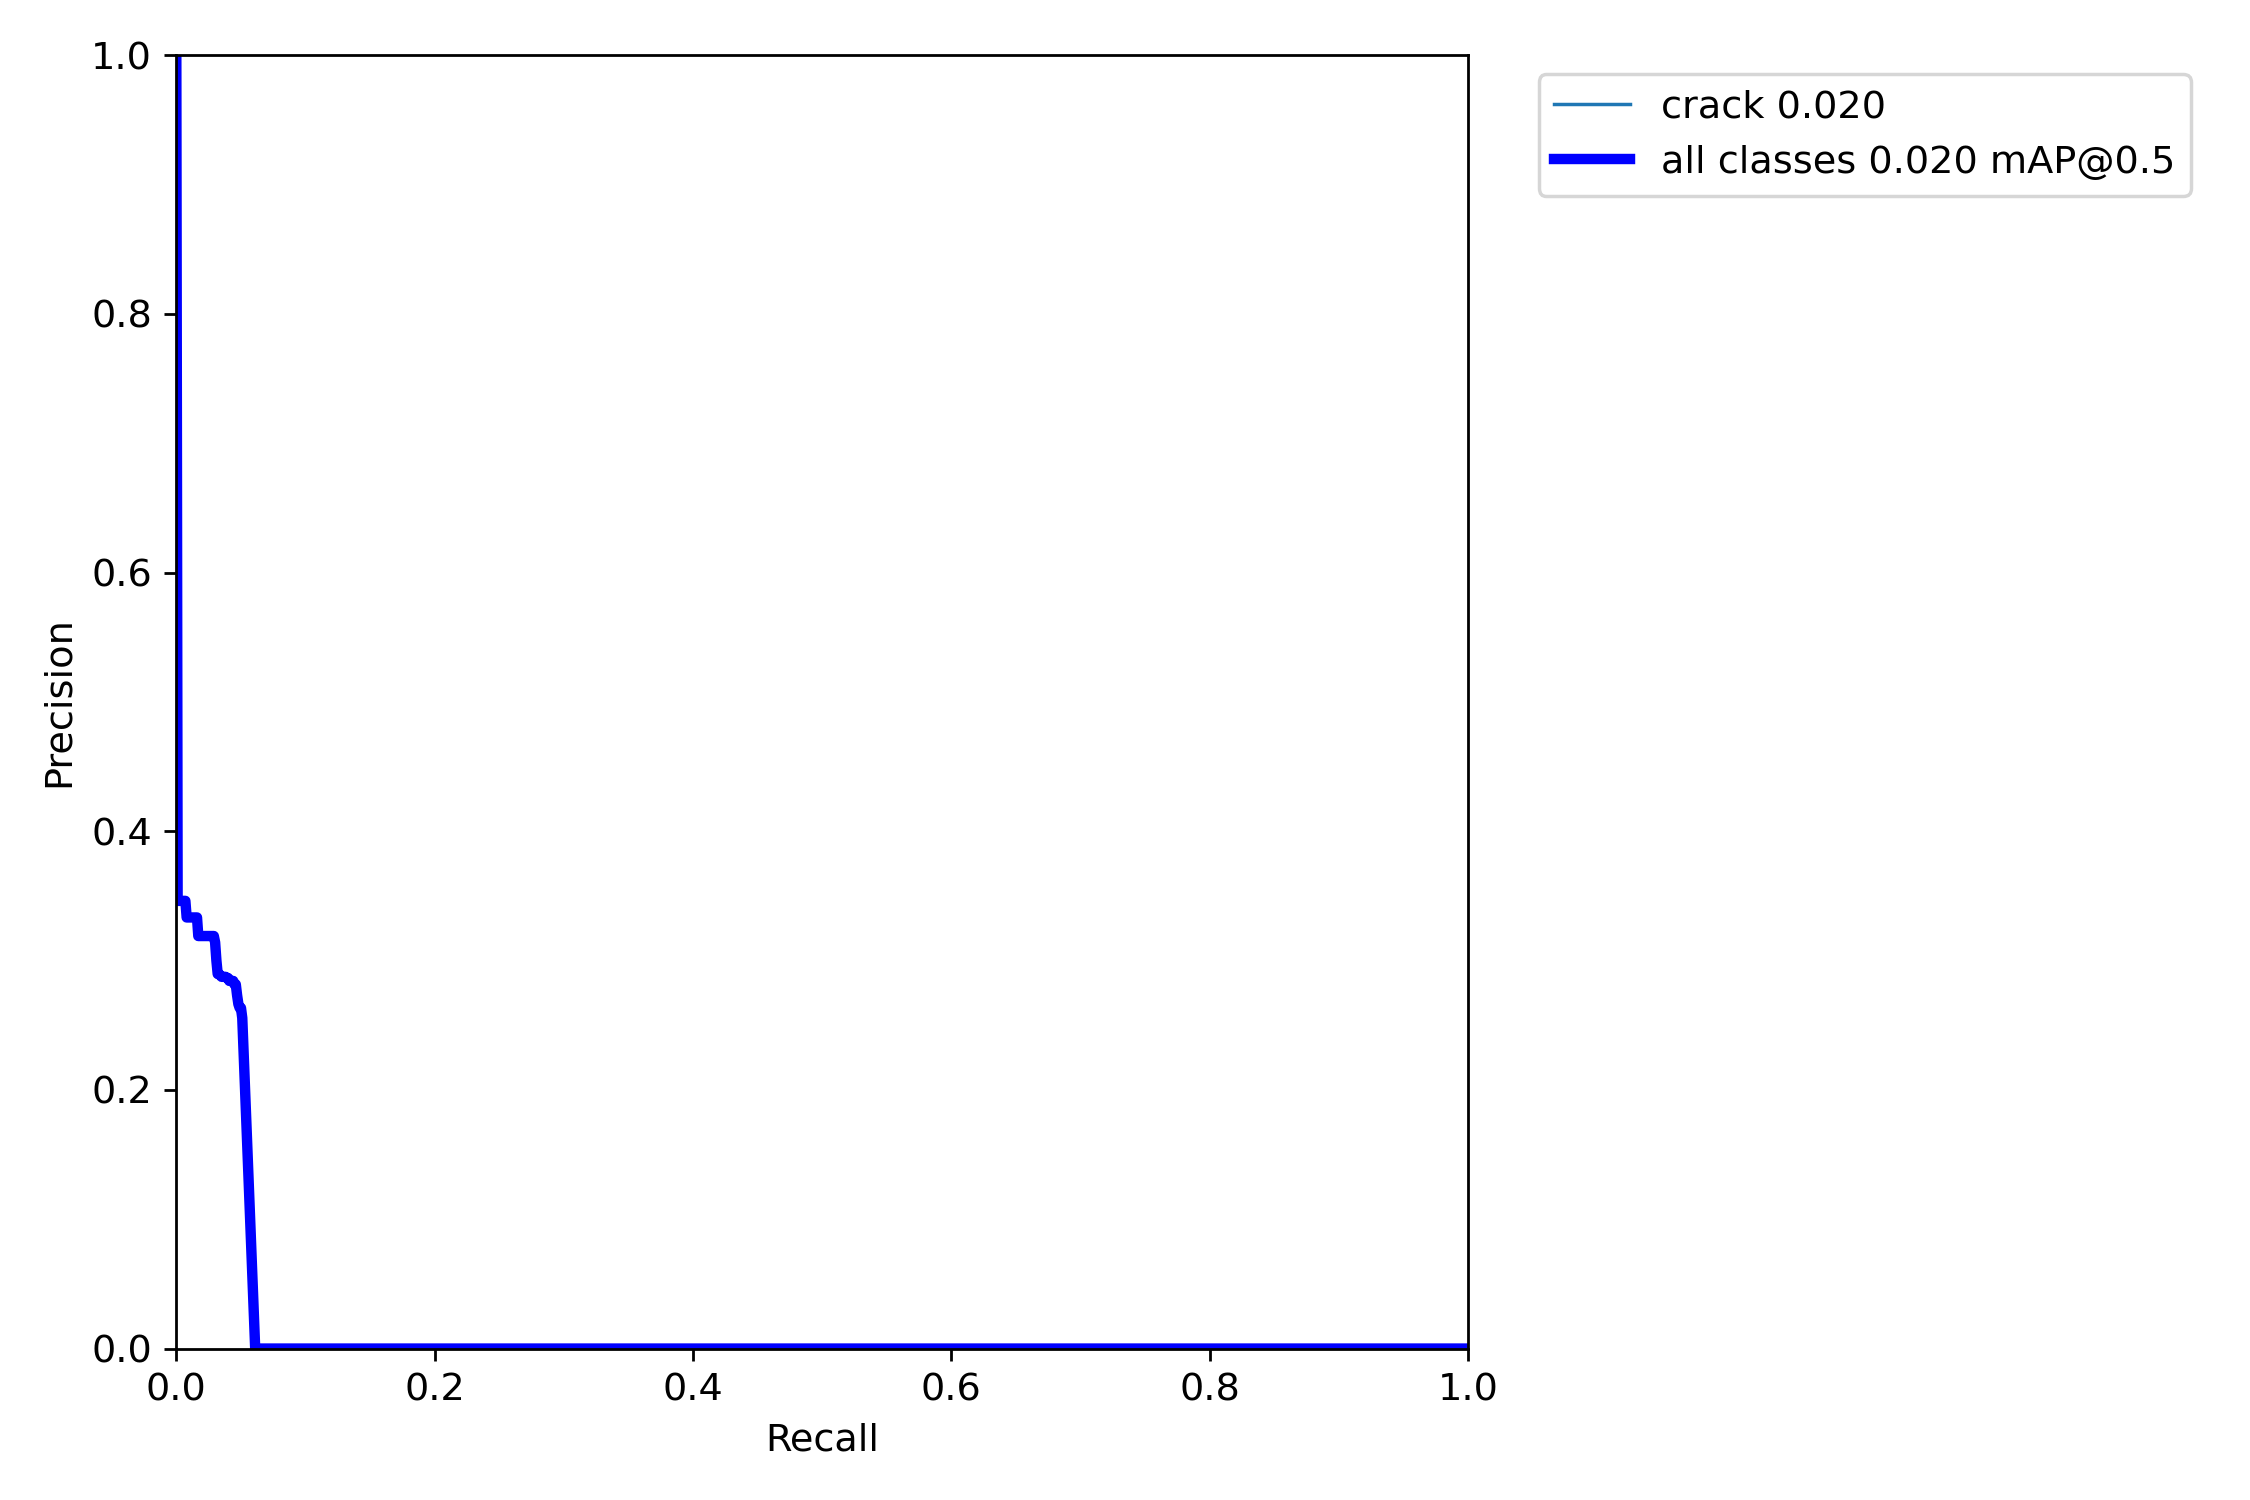

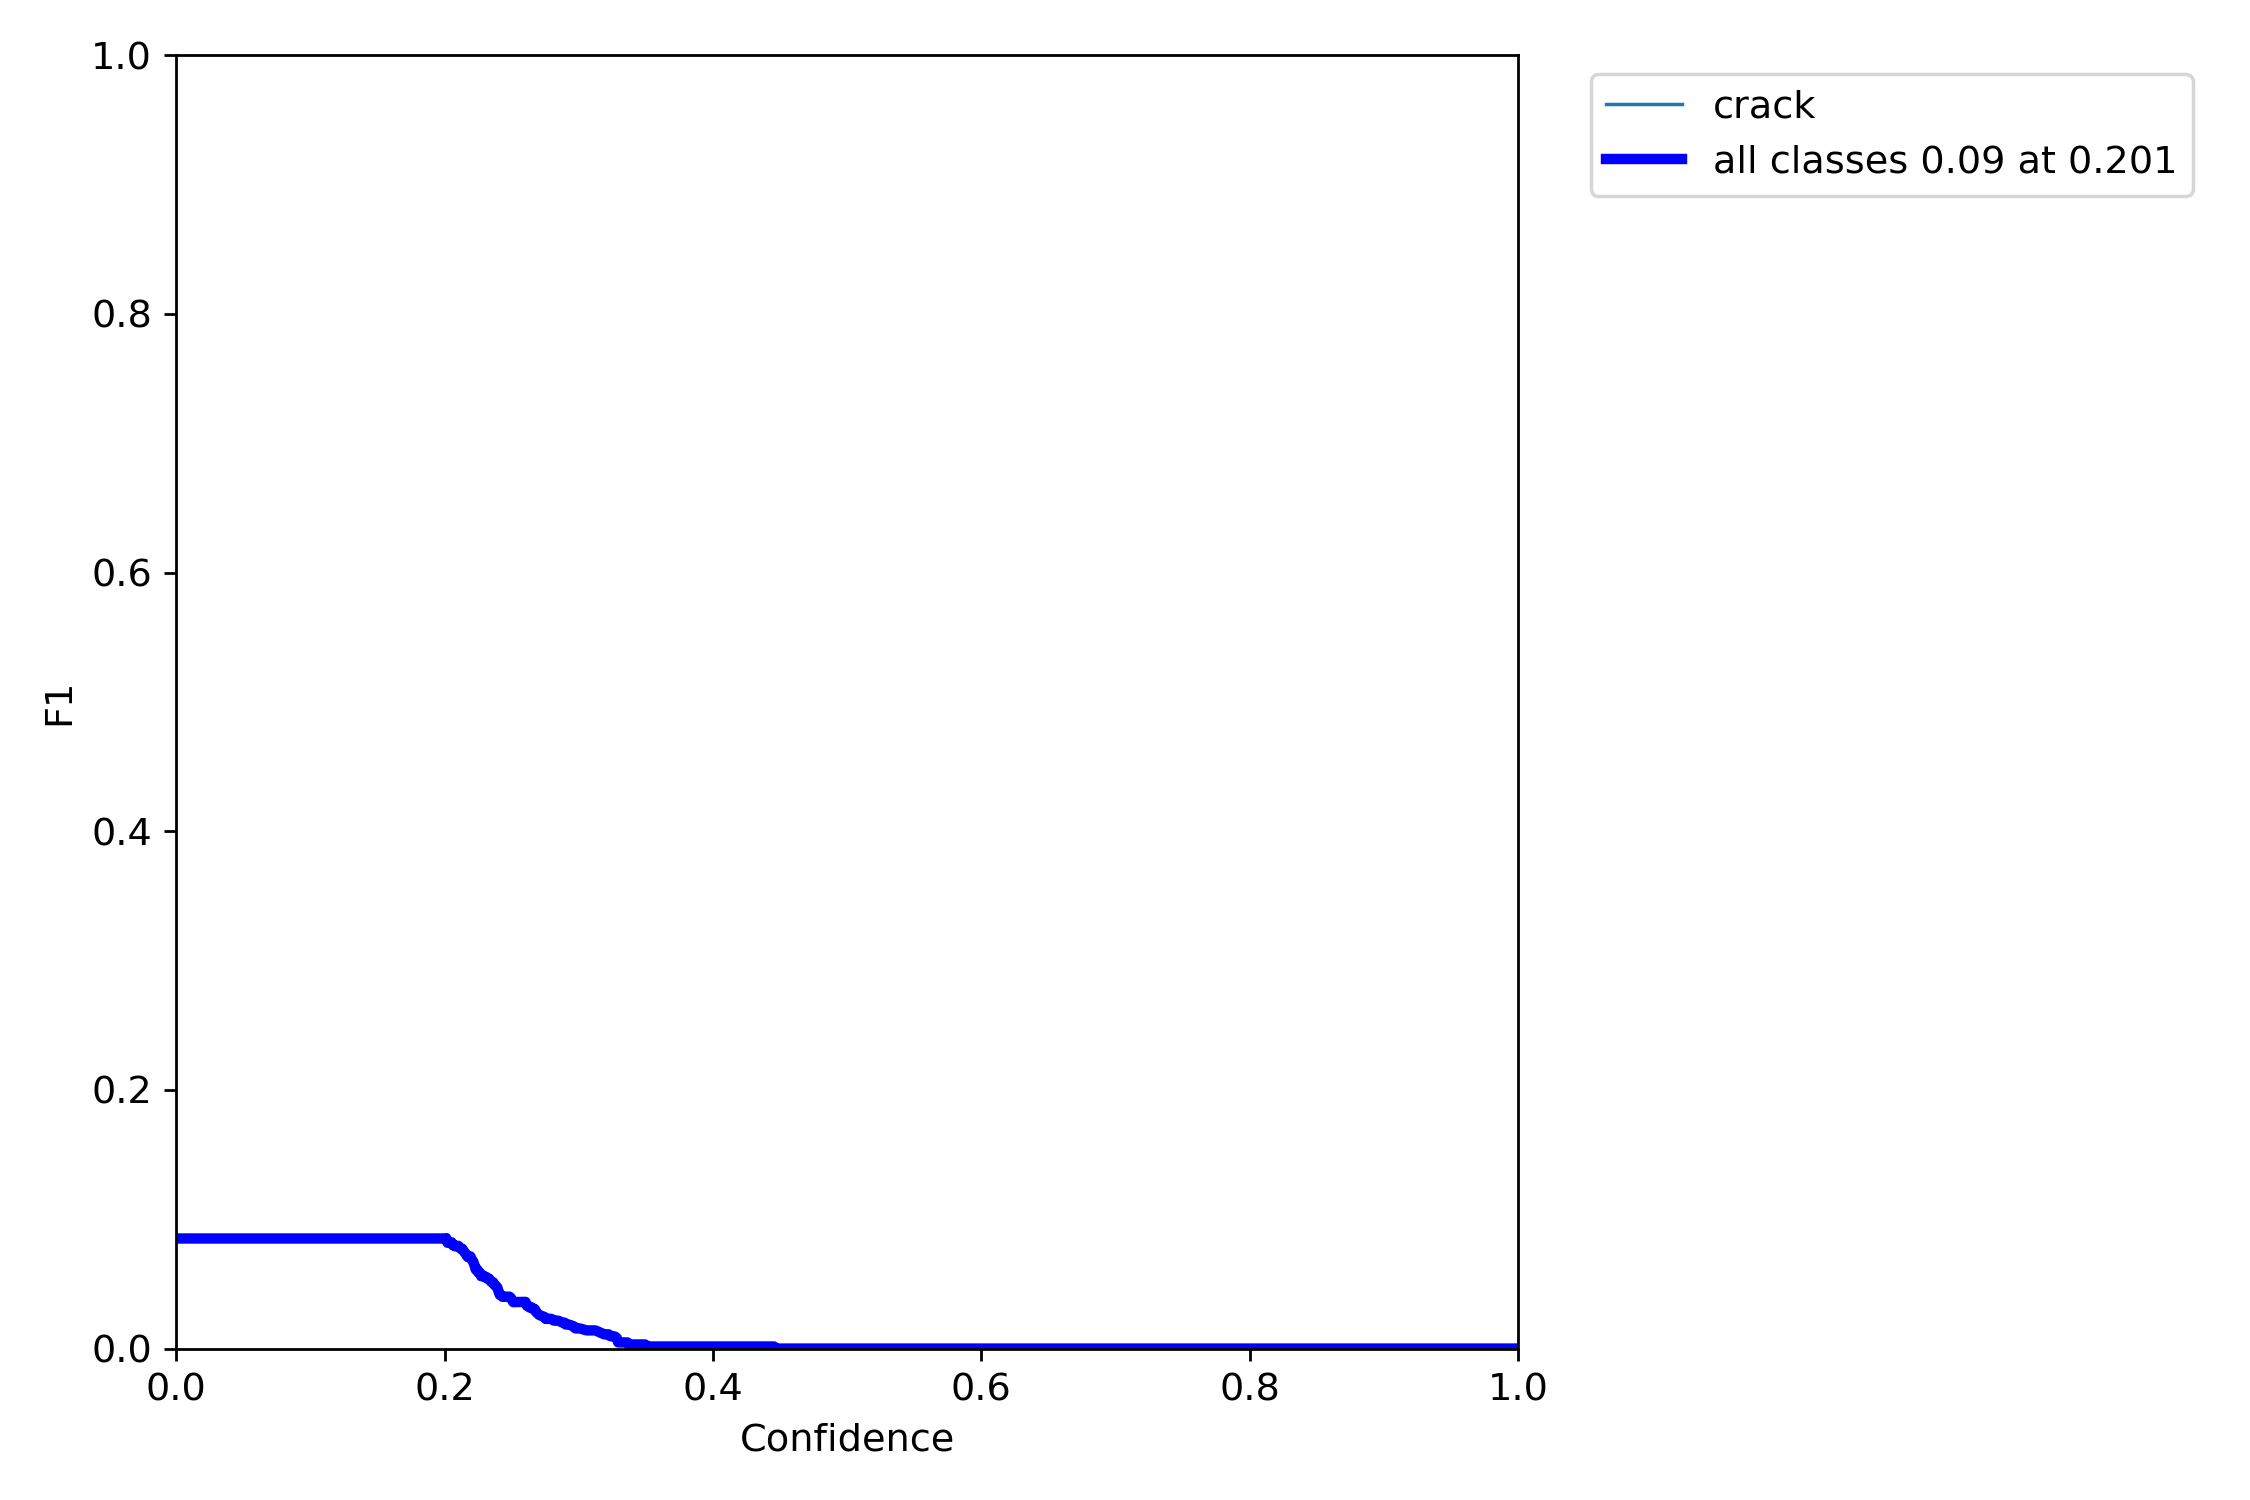

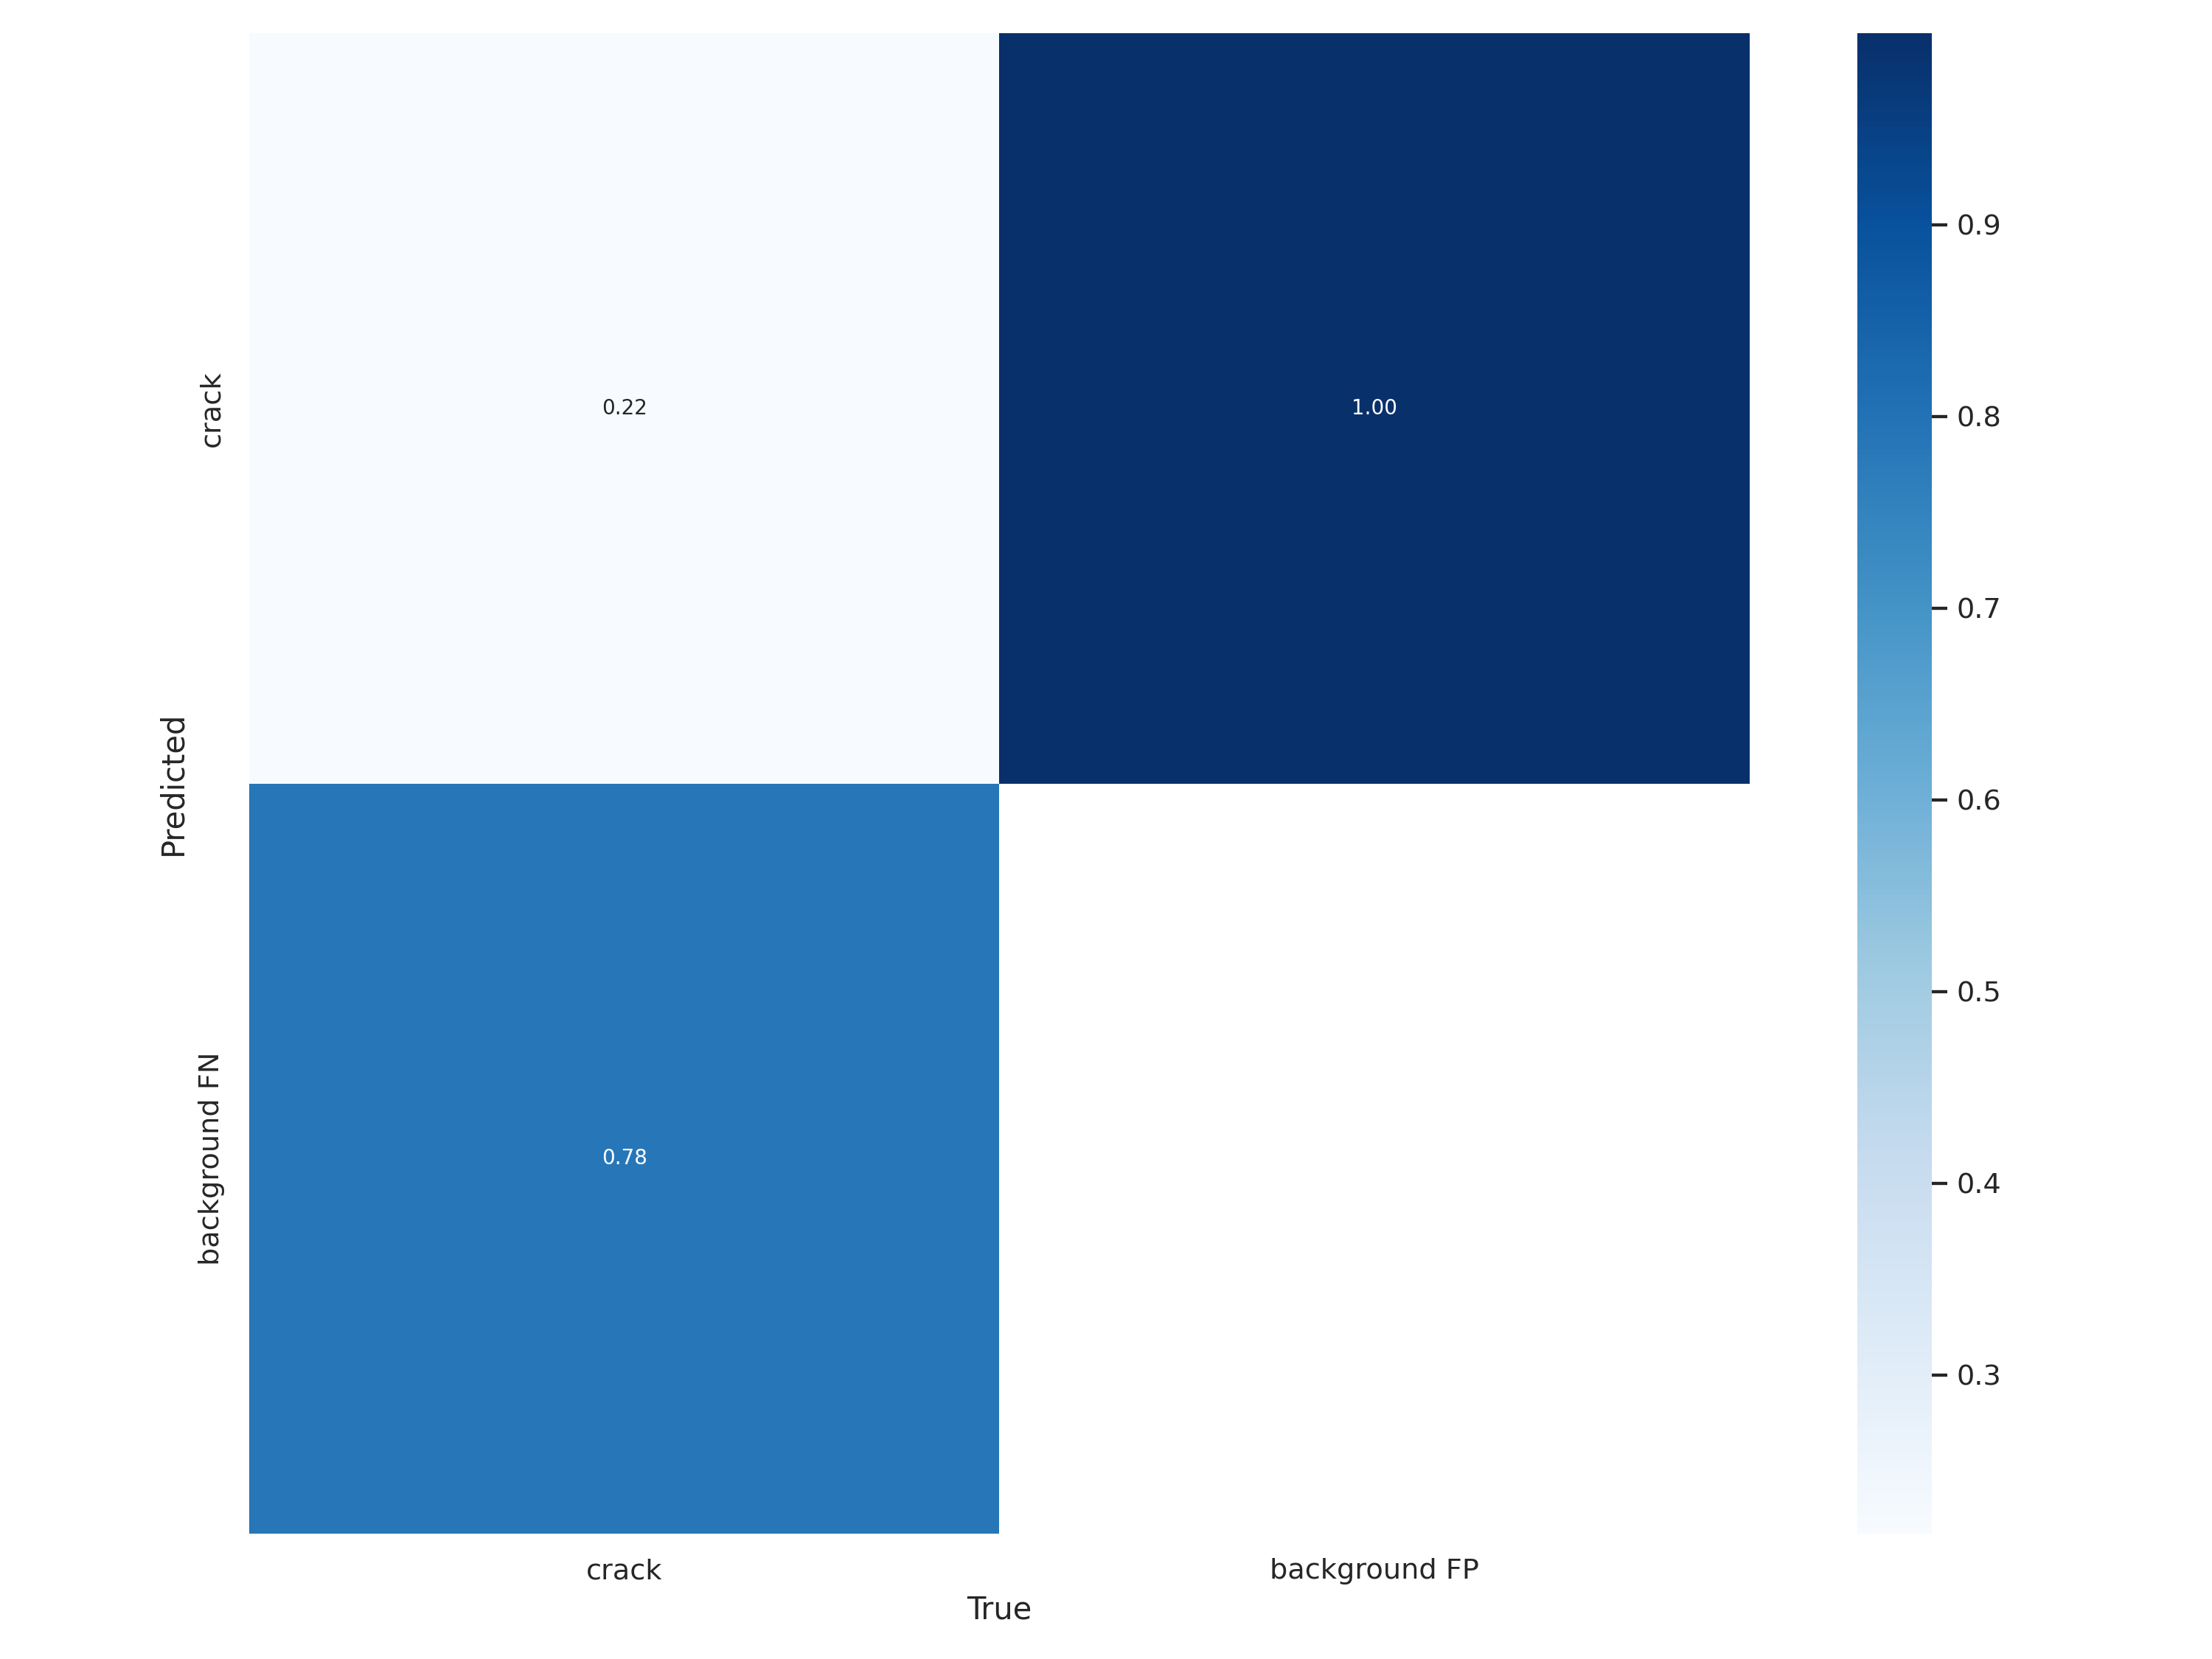

In [ ]:
from IPython.display import Image, display
display(Image(filename="/content/yolov7/runs/test/yolo_test_results/PR_curve.png"))
display(Image(filename="/content/yolov7/runs/test/yolo_test_results/F1_curve.png"))
display(Image(filename="/content/yolov7/runs/test/yolo_test_results/confusion_matrix.png"))
